# Call takeaway:
2. Možnost zastropování výdajů? 
3. Kouknout na Prokopa ještě tento týden
5. Potřebuji vůbec active vs inactive hhs? 


## Definitions

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pdb
idx = pd.IndexSlice

### Default parameters

použití parametrů viz níže

In [2]:
default_params = {
    'years':np.arange(20),
    'municipal_years_of_support':5,
    'private_years_of_support':2,
    'apartment_cost':25000, # 24000+7200 dle https://docs.google.com/document/d/1JAMspnkjakIaFpYuhAtch7sMhC5xd3dA/edit?usp=sharing&ouid=106125284349865545127&rtpof=true&sd=true 
    'private_yearly_apartments':5000, # Konzervativní odhad 2500 - 1 byt na měsíc pro každé ORP; Divoký odhad 10 000 bytl,
    'municipal_apartments_today': 200000,
    'municipal_yearly_new_apartments': 1000,
    'municipal_existing_availability_rate': .015,
    'municipal_new_availability_rate': .5,
    'active_current_hh_in_need':43250,
    'active_yearly_new_hh':2000,
    'inactive_current_hh_in_need':60000,
    'inactive_yearly_new_hh':500,
    'apartment_relapse_rate':.3, # share of hhs assigned to apartments returning to the system later
    'apartment_returnee_delay':1, # years after failed returnees enter the system again
    'soft_intervention_share':.2,
    'soft_relapse_rate':.5
}

 ## Nabídka - byty v systému

* Nabídka simuluje počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. Model simuluje zvlášť byty ze soukromého sektoru a byty, které jsou ve správě místních samospráv
* Nastavení modelu vede k  (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 5000 soukromých a pomalu rostoucích cca 3500 - 4000 městských bytů v systému ročně.

### Soukromé byty
* Nabídka soukromých bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `private_yearly_apartments`.
* Z komunikace s Romanem Matouškem proto vzešel návrh zvažovat tři scénáře: 
    - *Konzervativní* - 2 500 bytů ročně, tj. 10 bytů na ORP, tedy méně než 1 byt na ORP za měsíc
    - *Střední* - 5 000 bytů ročně
    - *Rozsáhlý* - 10 000 bytů ročně
* Pokud není řečeno jinak je použit *střední scénář* 

### Obecní byty
* Již dnes existuje cca 200 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 1,5 % uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - konzervativně předpokládáme 1000 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému výrazně větší část - klidně 50 % - `municipal_new_availability_rate`


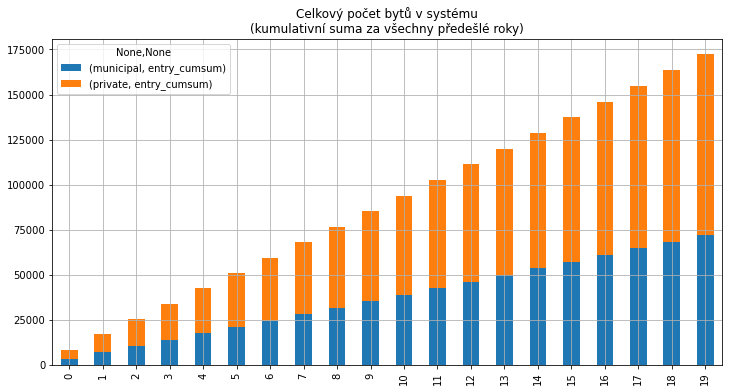

In [3]:
from supply import simulate_apartment_stock

apartments = simulate_apartment_stock(
    private_yearly_apartments=default_params['private_yearly_apartments'],
    municipal_apartments_today=default_params['municipal_apartments_today'],
    municipal_yearly_new_apartments=default_params['municipal_yearly_new_apartments'],
    municipal_existing_availability_rate=default_params['municipal_existing_availability_rate'],
    municipal_new_availability_rate=default_params['municipal_new_availability_rate'],
    years=default_params['years']
)
apartments.plot.bar(stacked=True, title='Celkový počet bytů v systému\n(kumulativní suma za všechny předešlé roky)',figsize=(12,6),grid=True);

## Poptávka - lidé v bytové nouzi

* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje *ekonomicky aktivní* domácnosti do *soukromých* bytů a *ekonomicky neaktivní* domácnosti do *obecních* bytů 
* Oba druhy domácností mají v čase lineární trend

### Ekonomicky aktivní 

* Dnešní počet ekonomicky aktivních domácností v bytové nouzi je 43 250 - `active_current_hh_in_need`. Vychází ze Zprávy o vyloučení z bydlení 2021
* Předpokládáme každoroční propad dalších 2000 domácností do bytové nouze -  `active_yearly_new_hh`.

### Ekonomicky neaktivní
* Dnešní počet ekonomicky aktivních domácností v bytové nouzi je 60 000 - `inactive_current_hh_in_need`. Myslím, že na radu Romana Matouška.
* Předpokládáme každoroční propad dalších 500 domácností do bytové nouze -  `inactive_yearly_new_hh`.

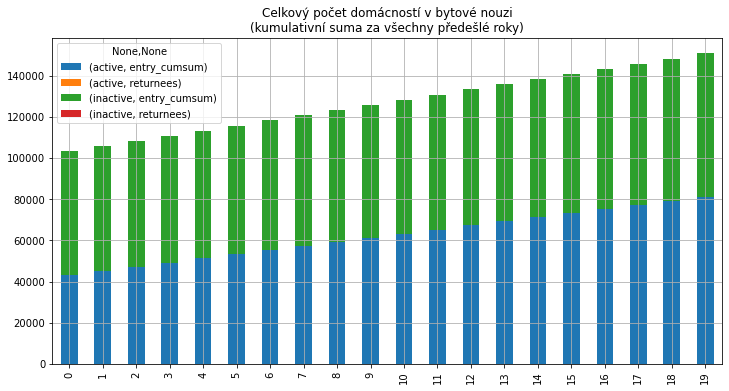

In [4]:
from demand import simulate_hh_stock

hhs = simulate_hh_stock(
    active_current_hh_in_need = default_params['active_current_hh_in_need'],
    active_yearly_new_hh = default_params['active_yearly_new_hh'],
    inactive_current_hh_in_need = default_params['inactive_current_hh_in_need'],
    inactive_yearly_new_hh = default_params['inactive_yearly_new_hh'],
    years = default_params['years']
)

hhs.plot.bar(stacked=True, grid=True, title='Celkový počet domácností v bytové nouzi\n(kumulativní suma za všechny předešlé roky)', figsize=(12,6));

## Vypořádání modelu
* Vypořádání probíhá každoročně
* V průběh vypořádání se v modelu rozdělují tzv. jednorázové podpory (*soft interventions*) a *přidělují se byty*. Zároveň určitá část domácností situaci nezvládne i přes státní podporu - role tzv. *navrátilců* (`returnees`).

### Jednorázové podpory
* Určitá část domácností v daném roce čekající na podporu - `soft_intervention_share` - dostane jednorázovou podporu a hned v dalším roce vystupují ze systému.
* Nicméně další část těchto domácností - `soft_relapse_rate` se hned další rok se dostane do systému znovu.

### Přiiřazování bytů
* Probíhá pro každou skupinu bytů i domácností zvlášť v předem daném pořadí
* Pro každou skupinu se určí kolik domácností podporu žádá a kolik bytů má daná skupina k dispozici. Všechny byty, které jsou k dispozici a po kterých je poptávka se takto přidělí.
* Přiřazování probíhá v následujícím pořadí, přičemž první dva body se vzájemně neruší
    1. Ekonomicky aktivní do soukromých bytů 
    2. Ekonomicky nekativní do obecních bytů
    3. Ekonomicky neaktivní do soukromých bytů
    4. Ekonomicky aktivní do obecních bytů
* Podpora v bydlení trvá omezenou dobu - `private_years_of_support` a `municipal_years_of_support`
* Nicméně další část těchto domácností - `soft_relapse_rate` se hned o nějakou dobu později - `apartment_returnee_delay` dostane do systému znovu.

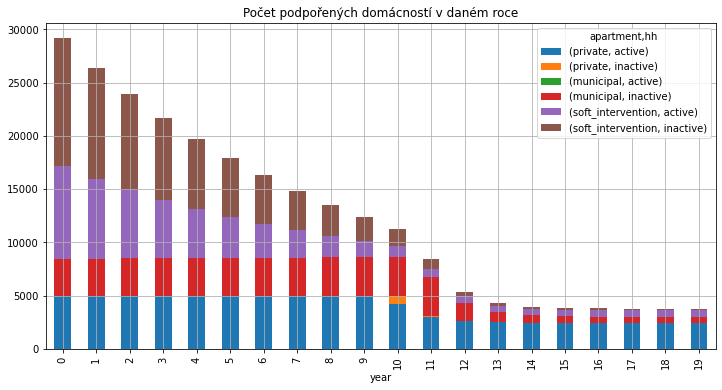

In [5]:
from main import generate_flows

flows = generate_flows(
    apartments=apartments,
    hhs=hhs, 
    apartment_relapse_rate=default_params['apartment_relapse_rate'],
    apartment_returnee_delay=default_params['apartment_returnee_delay'],
    years=default_params['years'],
    soft_relapse_rate=default_params['soft_relapse_rate'],
    soft_intervention_share=default_params['soft_intervention_share']
)
flows.unstack(['apartment','hh']).plot.bar(stacked=True, grid=True, figsize=(12,6),title='Počet podpořených domácností v daném roce');

## Simulace alternativ
* V následující sekci ukazuje možnosti modelu - zejména možnost posouvání jednotlivých parametrů a jejich vliv na výsledek
* Grafy níže rozdělují celkový počet domácností, které kdy do daného roku vstoupili do bytové nouze (kumulativně) do následujících kategorií:
    - `in_queue`  čekající na jakoukoliv podporu
    - `recent_soft` - soft intervence v tomto roce 
    - `currently_in_municipal` - umístěni do obecního bytu - 
    - `currently_in_private` - umístěni do soukromého bytu - 
    - `outside` - vystoupivší ze systému.
* Interpretaci tohoto grafu komplikují *relapses* - tedy podpořené domácnosti, které se ale přesto později do systému vrátili. V tuto chvíli jsou jednak v kategorii `outside`, ale ve stejný moment vstupují zároven zpět do systému do kategorie `in_queue`.

### Schopnost získat soukromé byty

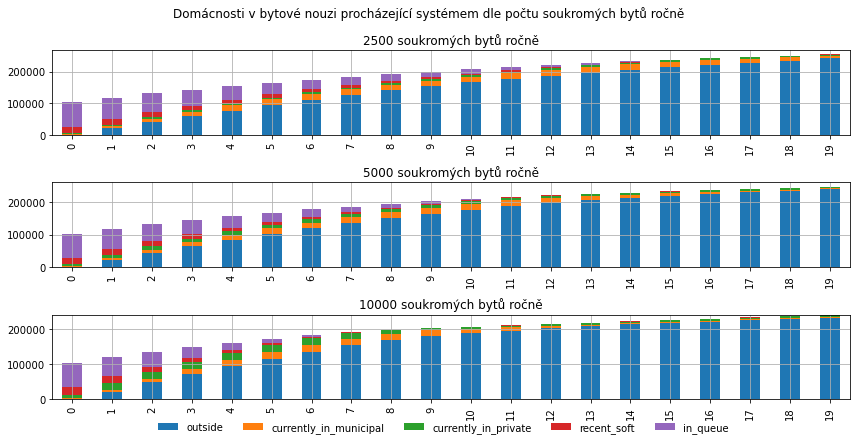

In [10]:
from main import simulate_social_housing

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(15,9))
config = {key:default_params[key] for key in default_params if key != 'private_yearly_apartments'}

for i, private_yearly_apartments in enumerate([2500,5000,10000]):
    flows,hhs_stats = simulate_social_housing(private_yearly_apartments=private_yearly_apartments ,**config)
    hhs_stats.stack(1).sum(axis=1).unstack()[['outside','currently_in_municipal','currently_in_private','recent_soft','in_queue']].plot.bar(stacked=True,figsize=(12,6),grid=True,ax=axs[i],title=f'{ private_yearly_apartments} soukromých bytů ročně',legend=False);
fig.suptitle('Domácnosti v bytové nouzi procházející systémem dle počtu soukromých bytů ročně')
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.18,0),ncol=5,frameon=False)
fig.tight_layout()

### Schopnost získat obecní byty

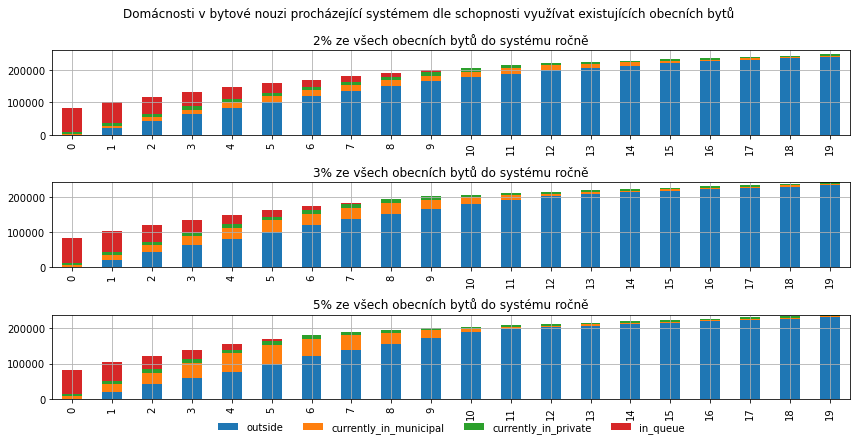

In [17]:
from main import simulate_social_housing

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(15,9))
config = {key:default_params[key] for key in default_params if key != 'municipal_existing_availability_rate'}

for i, municipal_existing_availability_rate in enumerate([0.015,0.03, 0.05]):
    flows,hhs_stats = simulate_social_housing(municipal_existing_availability_rate=municipal_existing_availability_rate ,**config)
    hhs_stats.stack(1).sum(axis=1).unstack()[['outside','currently_in_municipal','currently_in_private','in_queue']].plot.bar(stacked=True,figsize=(12,6),grid=True,ax=axs[i],title=f'{round(municipal_existing_availability_rate*100)}% ze všech obecních bytů do systému ročně',legend=False);
fig.suptitle('Domácnosti v bytové nouzi procházející systémem dle schopnosti využívat existujících obecních bytů')
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.25,0),ncol=4,frameon=False)
fig.tight_layout()

### Role tzv. soft intervencí
- například dávky mimořádné okamžité pomoci

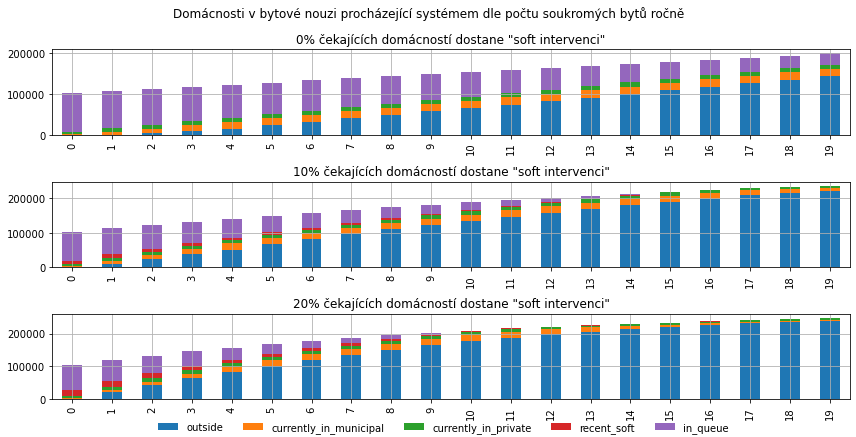

In [18]:
from main import simulate_social_housing

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(15,9))
config = {key:default_params[key] for key in default_params if key != 'soft_intervention_share'}

for i, soft_intervention_share in enumerate([.0,.1,.2]):
    flows,hhs_stats = simulate_social_housing(soft_intervention_share=soft_intervention_share ,**config)
    hhs_stats.stack(1).sum(axis=1).unstack()[['outside','currently_in_municipal','currently_in_private','recent_soft','in_queue']].plot.bar(stacked=True,figsize=(12,6),grid=True,ax=axs[i],title=f'{ round(soft_intervention_share*100)}% čekajících domácností dostane "soft intervenci"',legend=False);
fig.suptitle('Domácnosti v bytové nouzi procházející systémem dle počtu soukromých bytů ročně')
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.18,0),ncol=5,frameon=False)
fig.tight_layout()